# <a id='0'>Table of Contents</a>

$\textbf{Introduction}$

 - <a href='#11'>Problem and Motivation</a> 
 - <a href='#12'>Useful Definitions</a> 
 - <a href='#13'>Imports and File Directory Setup</a> 

$\textbf{Project Flowchart}$

$\textit{Data Acquisition}$

 - <a href='#211'> Data Sources</a>  
 - <a href='#212'> Data Scraping</a>
     
     
$\textit{Processing + Data Summary}$

 - <a href='#221'> Collating Files</a>  
 - <a href='#222'> Condensing Feature Space</a>  
 - <a href='#223'> Casting Columns</a>  
 - <a href='#224'> Synthetic Feature Development</a>  
 - <a href='#225'> Outlier Detection </a>  
 - <a href='#226'> Data Summary </a>  

$\textit{Model Updates and Next Steps}$

 - <a href='#231'> Performance Metrics Discussion</a>  
 - <a href='#231'> Neo4j Aura DB</a>  
 - <a href='#222'> Simple Graph Analysis with Clustering</a>  
 - <a href='#223'> More Sophisticated Models</a> 
 - <a href='#223'> Next Steps</a> 

$\textit{Appendix}$

 - <a href='#31'> Special Restricted Contract Types</a>  
 - <a href='#32'> Additional Questions</a>  

## Introduction

###  Problem and Motivation

$\textbf{What is the Problem?}$

Collusion and bid-rigging in public procurement inflate costs by up to 25%, costing the economy billions. Despite strong anti-collusion laws like the Sherman Act, identifying these practices is difficult due to evasive tactics and limited accessible data.

$\textbf{Why Does This Matter?}$

The economic damage caused by bid-rigging schemes is substantial, particularly in the public sector. Addressing these issues is essential for improving fairness in government contracting.

$\textbf{What is the Goal of This Project?}$

To create an automated anomaly detection tool that uses graph networks to identify suspicious procurement patterns early. This tool will help law enforcement agencies prioritize high-risk cases, speeding up the identification of collusion and reducing reliance on manual investigations.

$\textbf{Why Do I Care About This Project?}$

There has been prior work on ex-ante fraud detection in bidding processes, however there has been less work examining network analysis for government contracts.


### Useful Definitions

$\textbf{Public Procurement}$: The process by which government or public sector organizations acquire goods, services, or works from private companies, typically through a competitive bidding process.

$\textbf{Cartels}$: Groups of independent companies or organizations that collaborate to control prices, limit competition, or divide markets, often to their advantage.

$\textbf{Bid Rigging}$: A form of illegal collaboration where competitors secretly agree to manipulate the outcome of a bidding process, ensuring one party wins and the others benefit in some way

$\textbf{Sherman Act}$:  U.S. antitrust law enacted in 1890 that aims to prevent anti-competitive practices, such as monopolies, price-fixing, and other trade restrictions that harm consumers or competition.

$\textbf{Prime Contractors}$: Companies or organizations that have a direct contractual agreement with the a specific government agency to provide goods or services for a project.

$\textbf{Sub-Contractors/Subsidiaries}$: Companies or individuals hired by a prime contractor to perform specific tasks or provide services as part of a larger project.

$\textbf{Definitive Contracts}$: Contracts that are firm, with specific terms, conditions, and obligations that are legally enforceable, as opposed to less formal agreements or options that may not be binding.

$\textbf{PSC}$: Product Service Code (PSC) is a four-digit code used by the federal government to identify and classify the services, supplies, and equipment purchased under contract.

$\textbf{Solicitation Date}$: Refers to date a government agency issues a solicitation like an invitation to bid for potential vendors/suppliers, marking the start of the procurement process. 


$\textbf{Procurement Process}$: Agency -> Open/Restricted Competitive Bidding Process -> Prime Contractor -> Subsidiary



### Imports and File Directory Setup

In [14]:
### imports ###

# misc
from tqdm import tqdm
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

# file manipulation
import os

# img and graphs
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# unused libraries for scraping data
# import concurrent.futures
# from selenium.webdriver.common.by import By

# data processing
import math
import polars as pl
import us
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

In [15]:
cur_dir = os.getcwd()
assets_dir = os.path.join(cur_dir,'Image Assets Report')
data_dir = os.path.join(cur_dir, 'Data')
naics_data_dir = os.path.join(cur_dir, 'NAICS Processed')
bid_info_dir = os.path.join(cur_dir, 'Bid Info Downloader')
data_folder = [os.path.join(data_dir, i) for i in os.listdir(data_dir) if i != 'regions.pkl' and i != 'compressed_5000.csv']

---

## Project Flowchart  

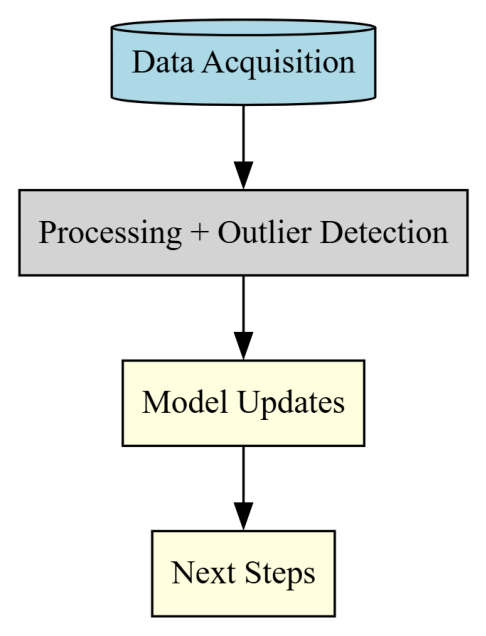

In [16]:
general_graph = os.path.join(assets_dir, 'general_graph.png')
img = mpimg.imread(general_graph)
plt.figure(figsize=(8, 8)) 
plt.imshow(img)
plt.axis('off')
plt.show()

---

### Data Acquisition

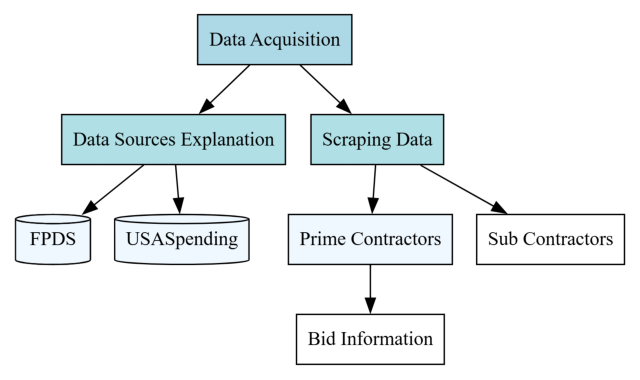

In [17]:
acq_graph = os.path.join(assets_dir, 'acq_graph.png')
img = mpimg.imread(acq_graph)
plt.figure(figsize=(8, 8)) 
plt.imshow(img)
plt.axis('off')
plt.show()

#### Data Sources

##### FPDS - Contract Network

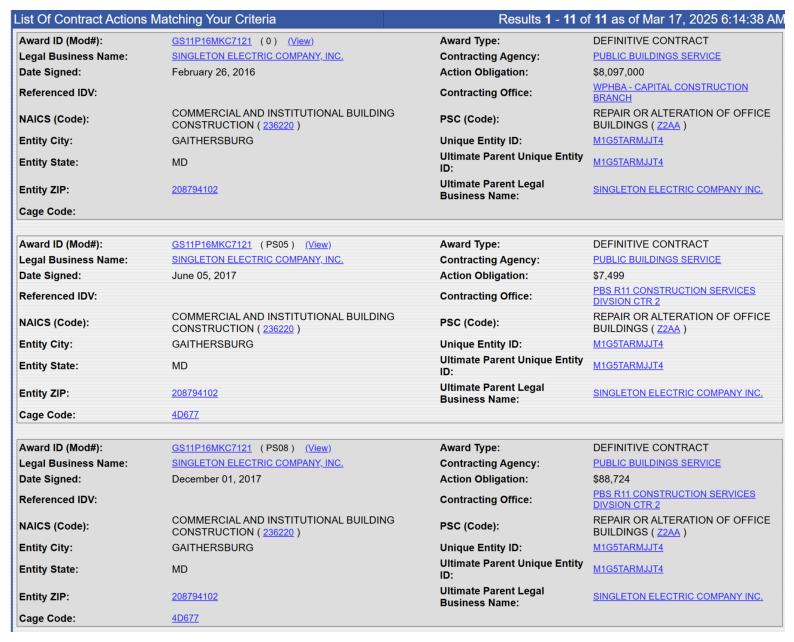

In [18]:
### render image ###
fpds_one = os.path.join(assets_dir, 'fpds_one.png')
img = mpimg.imread(fpds_one)
plt.figure(figsize=(10, 10)) 
plt.imshow(img)
plt.axis('off')
plt.show()

##### FPDS - Specific Contract

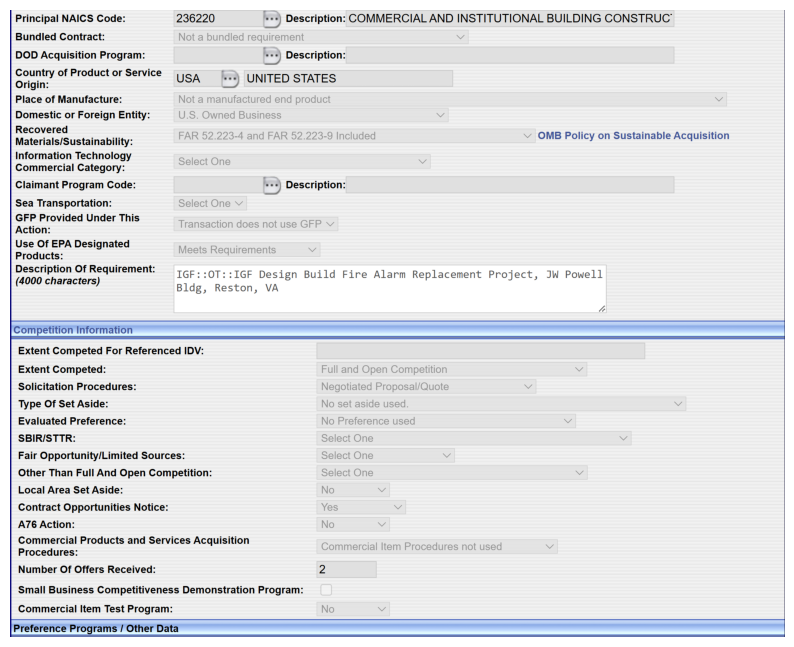

In [19]:
### render image ###
fpds_two = os.path.join(assets_dir, 'fpds_two.png')
img = mpimg.imread(fpds_two)
plt.figure(figsize=(10, 10)) 
plt.imshow(img)
plt.axis('off')
plt.show()

##### USASpending - Subaward Information

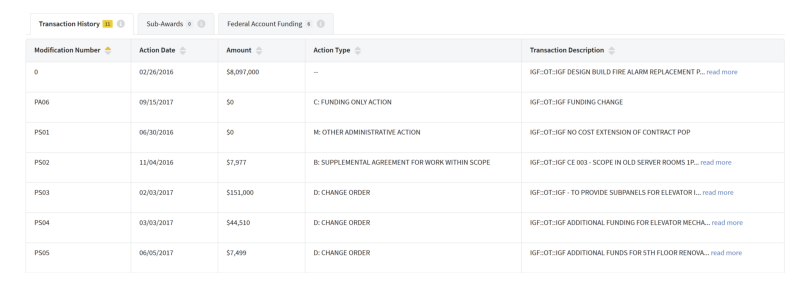

In [20]:
### render image ###
usaspending_one = os.path.join(assets_dir, 'usa_spending_one.png')
img = mpimg.imread(usaspending_one)
plt.figure(figsize=(10, 10)) 
plt.imshow(img)
plt.axis('off')
plt.show()

#### Data Scraping

##### FPDS - (Contract Network)

In [21]:
# subsect by month
driver = driversetup()

for i in tqdm(range(145, len(month_intervals))):
    driver.get(BASE_URL)
    query = f'PRINCIPAL_NAICS_CODE:"{naics_codes[0]}" SIGNED_DATE:[{month_intervals[i]}] AWARD_TYPE:"{award_type[0]}"'
    # input query into text box
    driver.find_element("id", "searchText").send_keys(query)
    # click search button
    driver.find_element(By.XPATH, "/html/body/form/table/tbody/tr[2]/td[2]/input").click()
    # click on csv download button
    csv_box = driver.find_elements("id", "csvImg")
    if csv_box:
        csv_box[0].click()
        # 10 second time delay to wait for download 
        time.sleep(10)
        # rename the downloaded file
        old_file_name = os.path.join(downloads_dir, 'SearchResults.csv')
        new_file_name = f'{naics_codes[0]}_{month_intervals[i].replace("/","_")}.csv'
        # move the renamed downloaded file to the data folder buffer directory
        move_location = os.path.join(data_dir, new_file_name)
        os.rename(old_file_name, move_location)
    
driver.quit()

NameError: name 'driversetup' is not defined

##### FPDS - (Specific Contract Information)

In [ ]:
# parallel processing - not consistent when merging processes

# processing a singl row
def process_row(row, driver):
    contract_id = row[0]
    agency_id = row[3]
    # defense contracts (mop up remaining)
    agency_id = agency_id if agency_id != '2100' else '9700'
    URL = f'https://www.fpds.gov/ezsearch/jsp/viewLinkController.jsp?agencyID={agency_id}&PIID={contract_id}&modNumber=0&transactionNumber=0&idvAgencyID=&idvPIID=&actionSource=searchScreen&actionCode=&documentVersion=1.0&contractType=AWARD&docType=D'
    driver.get(URL)
    try:
        extent = driver.find_element(By.CSS_SELECTOR, "#extentCompeted option:checked").text
    except:
        try:
            extent = driver.find_element(By.ID, "competitionInformationForDisplay").get_attribute("value")
        except:
            extent = 'Error'
    bid_num = driver.find_element(By.ID, "numberOfOffersReceived").get_attribute("value")
    return 'Open' if extent not in special_comp_params else 'Restricted', bid_num

# jobs sent to each thread
def process_rows(chunk, driver):
    comp_type = []
    bids = []
    for row in chunk:
        extent, bid_num = process_row(row, driver)
        comp_type.append(extent)
        bids.append(bid_num)
    return comp_type, bids

# chunking all the processes
def concurrent_process(df, ranges, num_workers=8):
    comp_type = []
    bids = []

    # pool
    drivers = [driversetup() for _ in range(num_workers)]

    # threads
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        
        chunk_size = 1000 
        for i in range(ranges[0], ranges[1], chunk_size):
            chunk = df[i:i+chunk_size]
            driver = drivers[i % num_workers]
            futures.append(executor.submit(process_rows, chunk, driver))
        
        # results
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing rows"):
            chunk_comp_type, chunk_bids = future.result()
            comp_type.extend(chunk_comp_type)
            bids.extend(chunk_bids)
    for driver in drivers:
        driver.quit()
    
    return comp_type, bids

ranges = (0, df.shape)
comp_type, bids = concurrent_process(df, ranges)

In [ ]:
# single process

# restricted competition types
special_comp_params = ["Follow On to Competed Action",
                       "Not Available for Competition",
                       "Not Competed"]

missing_dir = '/content/gdrive/MyDrive/Missing Bids/'
df = pl.read_csv(os.path.join(missing_dir, f'second_pass_missing_df.csv'))
driver = driversetup()
comp_type = []
bids = []
worker_num = 0
ranges = (0,953)

# run scraper for a specific number of rows
for row in tqdm(df[ranges[0]:ranges[1]].iter_rows(named=True), total=ranges[1]-ranges[0], desc="Processing rows"):
    contract_id = row['Contract ID']
    # agency_id = row['Contracting Agency ID']
    agency_id = '9700'
    URL = f'https://www.fpds.gov/ezsearch/jsp/viewLinkController.jsp?agencyID={agency_id}&PIID={contract_id}&modNumber=0&transactionNumber=0&idvAgencyID=&idvPIID=&actionSource=searchScreen&actionCode=&documentVersion=1.5&contractType=AWARD&docType=D'
    driver.get(URL)
    # get extent competed and bids
    try:
        extent = driver.find_element(By.CSS_SELECTOR, "#extentCompeted option:checked").text
    except:
        time.sleep(0.5)
        extent = driver.find_element(By.ID, "competitionInformationForDisplay").get_attribute("value")
    bid_num = driver.find_element(By.ID, "numberOfOffersReceived").get_attribute("value")
    # add to lists
    comp_type.append('Open' if extent not in special_comp_params else 'Restricted')
    bids.append(bid_num)

# merge the scraped information with initial dataframe
merged_df = df.with_columns([
    pl.Series('Competition Type', comp_type),
    pl.Series('Bids', bids)
])

# save the csv
save_dir = os.path.join(missing_dir, f'Worker{worker_num}_second_pass_data.csv')
merged_df.write_csv(save_dir)

##### USASpending - (Subsidiary Info) (Omit for Report since few prime contractors list sub contracting info and need to recheck and validate)

In [ ]:
from selenium.common.exceptions import ElementClickInterceptedException

work_num = 3

# dataframe setup
file_name_summary = [i for i in os.listdir(sub_dir) if f'Worker{work_num}' in i and 'summary' in i][0]
file_name_specific = [i for i in os.listdir(sub_dir) if f'Worker{work_num}' in i and 'subaward' in i][0]
file_loc_summary = os.path.join(sub_dir, file_name_summary)
file_loc_specific = os.path.join(sub_dir, file_name_specific)
df = pd.read_csv(file_loc_summary)

# driver setup
driver = driversetup()

# scraping

for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    contract_id = row['Contract ID']
    agency_id = row['Contracting Agency ID']
    agency_id = agency_id if agency_id != '2100' else '9700'
    num_sub = row['Number of Sub-Award Transactions']
    sum_sub = row['Sub-Award Obligation Sum']
    percent_sub = row['Percent of Prime Award (Sub-Award)']
    # define some strings
    nums = ''
    sums = ''
    perc = ''
    # checks
    if num_sub != 'Empty' and num_sub != '':
        nums = num_sub
    if sum_sub != 'Empty' and sum_sub != '':
        sums = sum_sub
    if percent_sub != 'Empty' and percent_sub != '':
        perc = percent_sub
    URL = f'https://www.usaspending.gov/award/CONT_AWD_{contract_id}_{agency_id}_-NONE-_-NONE-'
    try:
        driver.get(URL)
    except:
        continue
    time.sleep(2)
    # click on sub awards button
    try:
        driver.find_element(By.XPATH, "/html/body/div/div/main/div/div[6]/div/div[2]/div[1]/div[3]/div").click()
    except (NoSuchElementException, ElementClickInterceptedException):
        continue
    time.sleep(2)
    # get num sub
    
    if nums == '':
        try:
            nums = driver.find_element(By.XPATH, "/html/body/div/div/main/div/div[6]/div/div[2]/div[2]/div[1]/div/div[1]/div/div/div[2]").text
        except NoSuchElementException:
            try:
                time.sleep(0.5)
                nums = driver.find_element(By.XPATH, "/html/body/div/div/main/div/div[6]/div/div[2]/div[2]/div[1]/div/div[1]/div/div/div[2]").text
            except NoSuchElementException:
                nums = ''
        df.at[index, 'Number of Sub-Award Transactions'] = nums
    # get sum
    if sums == '':
        try:
            if nums == 0:
                sums = 0
            else:
                sums = driver.find_element(By.XPATH, "/html/body/div/div/main/div/div[6]/div/div[2]/div[2]/div[1]/div/div[2]/div/div/div[2]").text
        except NoSuchElementException:
            time.sleep(0.5)
            try:
                sums = driver.find_element(By.XPATH, "/html/body/div/div/main/div/div[6]/div/div[2]/div[2]/div[1]/div/div[2]/div/div/div[2]").text
            except NoSuchElementException:
                sums = ''
        df.at[index, 'Sub-Award Obligation Sum'] = sums
    # get percent
    if perc == '':
        try:
            if nums == 0:
                perc = 0
            else:
                perc = driver.find_element(By.XPATH, "/html/body/div/div/main/div/div[6]/div/div[2]/div[2]/div[1]/div/div[3]/div/div/div[2]").text
        except NoSuchElementException:
            time.sleep(0.5)
            try:
                perc = driver.find_element(By.XPATH, "/html/body/div/div/main/div/div[6]/div/div[2]/div[2]/div[1]/div/div[3]/div/div/div[2]").text
            except NoSuchElementException:
                perc = ''
        df.at[index, 'Percent of Prime Award (Sub-Award)'] = perc
    df.to_csv(file_loc_summary)
df.head()
    

### Processing

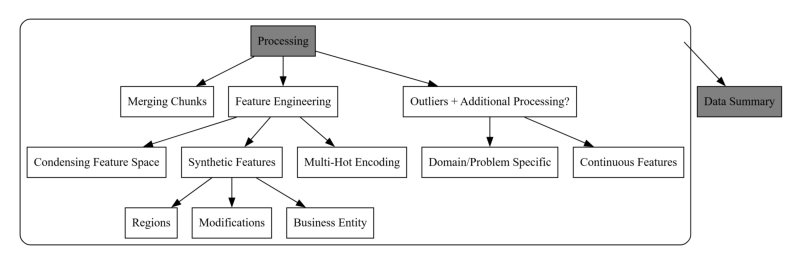

In [13]:
proc_graph = os.path.join(assets_dir, 'proc_graph.png')
img = mpimg.imread(proc_graph)
plt.figure(figsize=(10, 10)) 
plt.imshow(img)
plt.axis('off')
plt.show()

#### Merging Chunks (Collating Files)

In [22]:
samp_df = pl.read_csv(data_folder[0])
df_dict = {str(year): pl.DataFrame(schema={col: pl.Utf8 for col in samp_df.columns}) for year in range(2000, 2025)}

for interval in data_folder:
    year = interval[67:71]
    dtypes = {col: pl.Utf8 for col in samp_df.columns}
    cur_df = pl.read_csv(interval,dtypes = dtypes, encoding="utf8-lossy")
    cur_df = cur_df.filter(cur_df["Modification Number"] == "0")
    df_dict[year] = df_dict[year].vstack(cur_df)

In [23]:
non_proc_combined_df = pl.DataFrame(schema={col: pl.Utf8 for col in samp_df.columns})

for interval in data_folder:
    cur_df = pl.read_csv(interval,dtypes = dtypes, encoding="utf8-lossy")
    non_proc_combined_df = non_proc_combined_df.vstack(cur_df)
    
print(f'Total Entries: {non_proc_combined_df.shape[0]}')
non_proc_combined_df.head()

Total Entries: 323005


Contract ID,Reference IDV,Modification Number,Transaction Number,Award/IDV Type,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,NAICS Description,Entity City,Entity State,Entity ZIP Code,Additional Reporting Code,Additional Reporting Description,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name,Legal Business Name,CAGE Code,
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""0036CC10252""",null,"""0""","""0""","""DCA Definitive Contract""","""$1,184,112.00""","""Mar 7, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""EL DORADO""",null,null,null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…","""construcciones electronmecanic…",null,null
"""EX000200005DGS04P99EXC0014""",null,"""PSR3""","""0""","""DCA Definitive Contract""","""$48,222.00""","""May 15, 2000""",null,"""4740""","""PUBLIC BUILDINGS SERVICE""","""ACQUISITION DIVISION/NON-PROSP…","""S""","""Z111""","""MAINT-REP-ALT/OFFICE BLDGS""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""MONTGOMERY""","""AL""","""361091100""",null,null,"""KJ1ZS574VV73""","""KJ1ZS574VV73""","""CADDELL CONSTRUCTION CO. INC.""","""CADDELL CONSTRUCTION COMPANY,""",null,null
"""V0010F200006DV101BC0180""",null,"""0""","""0""","""DCA Definitive Contract""","""$0.00""","""Jun 15, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""NATIONAL CEMETERY ADMINISTRATI…","""S""","""Y219""","""CONSTRUCT/OTHER CONSERVATION""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""BROOKSVILLE""","""FL""","""346028213""",null,null,"""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…","""CASCADE MECHANICAL INCORPORATE…",null,null
"""GS06P06GYC0017""",null,"""PC04""","""0""","""DCA Definitive Contract""","""$1,800.00""","""Jul 12, 2000""",null,"""4740""","""PUBLIC BUILDINGS SERVICE""","""GSA/PUBLIC BUILDINGS SERVICE""","""S""","""Z111""","""MAINT-REP-ALT/OFFICE BLDGS""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""WEST DES MOINES""","""IA""","""502654754""",null,null,"""Q8ZEUC48K3K9""","""Q8ZEUC48K3K9""","""NUNO ELECTRIC LLC""","""NUNO ELECTRIC LIMITED LIABILIT…",null,null
"""GS06P06GYC0017""",null,"""PC06""","""0""","""DCA Definitive Contract""","""$229.90""","""Jul 12, 2000""",null,"""4740""","""PUBLIC BUILDINGS SERVICE""","""GSA/PUBLIC BUILDINGS SERVICE""","""S""","""Z111""","""MAINT-REP-ALT/OFFICE BLDGS""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""WEST DES MOINES""","""IA""","""502654754""",null,null,"""Q8ZEUC48K3K9""","""Q8ZEUC48K3K9""","""NUNO ELECTRIC LLC""","""NUNO ELECTRIC LIMITED LIABILIT…",null,null


In [24]:
combined_df = pl.DataFrame(schema={col: pl.Utf8 for col in samp_df.columns})
for key in df_dict:
    combined_df = combined_df.vstack(df_dict[key])

combined_df = combined_df.unique(maintain_order=True)
print(f'Total Entries: {combined_df.shape[0]}')
combined_df.head()

Total Entries: 56442


Contract ID,Reference IDV,Modification Number,Transaction Number,Award/IDV Type,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,NAICS Description,Entity City,Entity State,Entity ZIP Code,Additional Reporting Code,Additional Reporting Description,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name,Legal Business Name,CAGE Code,
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""0036CC10252""",null,"""0""","""0""","""DCA Definitive Contract""","""$1,184,112.00""","""Mar 7, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""EL DORADO""",null,null,null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…","""construcciones electronmecanic…",null,null
"""V0010F200006DV101BC0180""",null,"""0""","""0""","""DCA Definitive Contract""","""$0.00""","""Jun 15, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""NATIONAL CEMETERY ADMINISTRATI…","""S""","""Y219""","""CONSTRUCT/OTHER CONSERVATION""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""BROOKSVILLE""","""FL""","""346028213""",null,null,"""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…","""CASCADE MECHANICAL INCORPORATE…",null,null
"""0036CC10543""",null,"""0""","""0""","""DCA Definitive Contract""","""$1,003,227.00""","""Sep 5, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""UPPER MARLBORO""","""MD""","""207742456""",null,null,"""H2XFGR46UMA1""","""H2XFGR46UMA1""","""K-LO CONSTRUCTION INCORPORATED""","""K LO CONSTRUCTION INCORPORATED""",null,null
"""V623C723""",null,"""0""","""0""","""DCA Definitive Contract""","""$57,920.00""","""Sep 7, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""623-MUSKOGEE""","""S""","""Y141""","""CONSTRUCT/HOSPITALS & INFIRMAR…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""BROKEN ARROW""","""OK""","""740144811""",null,null,"""J9B5J1JFPEK3""","""J9B5J1JFPEK3""","""C3 LLC""","""C3 LIMITED LIABILITY COMPANY""",null,null
"""INICMH00010011""",null,"""0""","""0""","""DCA Definitive Contract""","""$195,500.00""","""Mar 19, 2001""",null,"""1450""","""BUREAU OF INDIAN AFFAIRS""","""WESTERN REGIONAL OFFICE""","""S""","""Z166""","""MAINT-REP-ALT/PENAL FACILITIES""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""TUCSON""","""AZ""","""857196742""",null,null,"""GM9SKMQCH5N5""","""GM9SKMQCH5N5""","""M.G.M. ASSOCIATES INC.""","""M G M ASSOCIATES INCORPORATED""",null,null


#### Condensed Feature Space and Casting

In [25]:
drop_columns = ['Reference IDV', 
                'Modification Number', 
                'Award/IDV Type', 
                'NAICS Description', 
                'Additional Reporting Code', 
                'Additional Reporting Description',
                'CAGE Code',
                'Transaction Number',
                'Legal Business Name',
                'Solicitation Date',
                'Contracting Agency',
                'Contracting Office Name',
                'PSC Type',
                'PSC Description',
                '']


combined_df = combined_df.drop(drop_columns)

# action obligation changing
combined_df = combined_df.with_columns(
    pl.col("Action Obligation ($)")
    .str.replace_all(r"[\$,]", "")
    .str.replace_all(r"\..*", "")
    .str.strip_chars()
    .cast(pl.Int64)
)

# dates
combined_df = combined_df.with_columns(
    pl.col("Date Signed").str.strptime(pl.Date, "%b %d, %Y", strict=False)
)

# changing NAICS to int
combined_df = combined_df.with_columns(
    pl.col("NAICS").cast(pl.Int64)
)

combined_df.head()

Contract ID,Action Obligation ($),Date Signed,Contracting Agency ID,PSC,NAICS,Entity City,Entity State,Entity ZIP Code,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name
str,i64,date,str,str,i64,str,str,str,str,str,str
"""0036CC10252""",1184112,2000-03-07,"""3300""","""Z191""",236220,"""EL DORADO""",null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…"
"""V0010F200006DV101BC0180""",0,2000-06-15,"""3600""","""Y219""",236220,"""BROOKSVILLE""","""FL""","""346028213""","""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…"
"""0036CC10543""",1003227,2000-09-05,"""3300""","""Z191""",236220,"""UPPER MARLBORO""","""MD""","""207742456""","""H2XFGR46UMA1""","""H2XFGR46UMA1""","""K-LO CONSTRUCTION INCORPORATED"""
"""V623C723""",57920,2000-09-07,"""3600""","""Y141""",236220,"""BROKEN ARROW""","""OK""","""740144811""","""J9B5J1JFPEK3""","""J9B5J1JFPEK3""","""C3 LLC"""
"""INICMH00010011""",195500,2001-03-19,"""1450""","""Z166""",236220,"""TUCSON""","""AZ""","""857196742""","""GM9SKMQCH5N5""","""GM9SKMQCH5N5""","""M.G.M. ASSOCIATES INC."""


#### Synthetic Feature Development + Supplementary Processing

##### Region

In [26]:
state_to_region = {
    "ME": "Northeast", "NH": "Northeast", "VT": "Northeast", "MA": "Northeast",
    "RI": "Northeast", "CT": "Northeast", "NY": "Northeast", "NJ": "Northeast",
    "PA": "Northeast", "DE": "Southeast", "MD": "Southeast", "VA": "Southeast",
    "WV": "Southeast", "KY": "Southeast", "NC": "Southeast", "SC": "Southeast",
    "TN": "Southeast", "GA": "Southeast", "FL": "Southeast", "AL": "Southeast",
    "DC": "Southeast", "MS": "Southeast", "LA": "Southeast", "AR": "Southeast", 
    "MO": "Midwest", "OH": "Midwest", "IN": "Midwest", "IL": "Midwest", "MI": "Midwest",
    "WI": "Midwest", "MN": "Midwest", "IA": "Midwest", "ND": "Midwest",
    "SD": "Midwest", "NE": "Midwest", "KS": "Midwest", "MT": "West",
    "ID": "West", "WY": "West", "CO": "West", "UT": "West", "NV": "West",
    "CA": "West", "OR": "West", "WA": "West", "AK": "West", "HI": "West",
    "TX": "Southwest", "OK": "Southwest", "NM": "Southwest", "AZ": "Southwest"
}

In [27]:
def get_state_from_zip(zip_code):
    geolocator = Nominatim(user_agent="geocoding_app")
    location = geolocator.geocode(zip_code, addressdetails=True)
    
    if location and location.raw.get('address'):
        address_data = location.raw['address']
        state = address_data.get('state') or address_data.get('province')
        return state
    else:
        return None

In [28]:
def get_state_from_city(city_name):
    geolocator = Nominatim(user_agent="geocoding_app")
    location = geolocator.geocode(city_name, addressdetails=True)
    
    if location and location.raw.get('address'):
        address_data = location.raw['address']
        state = address_data.get('state') or address_data.get('province')
        return state
    else:
        return None

In [29]:
def get_state_abbreviation(state_name: str):
    """Convert full state name to abbreviation (e.g., 'California' -> 'CA')."""
    state = us.states.lookup(state_name)
    return state.abbr if state else None

In [16]:
def assign_region(row_city, row_state, row_zip_code):
    state = None
    
    if row_state:
        if row_state not in state_to_region.keys():
            return "Unknown"
        return state_to_region[row_state]
    
    if row_city and not row_zip_code:
        state = get_state_from_city(row_city)
    if row_zip_code and not row_city:
        state = get_state_from_zip(row_zip_code)

    if state:
        time.sleep(0.5)
        state_abr = get_state_abbreviation(state)
        if state_abr in state_to_region:
            return state_to_region[state_abr]
    return "Unknown"

In [ ]:
# don't run again

regions = []

for row in tqdm(combined_df.iter_rows(), total=combined_df.height, desc="Processing rows"):
    city = row[11]
    state = row[12]
    zip_code = row[13]
    region = assign_region(city, state, zip_code)
    regions.append(region)

regions[:10]

In [30]:
# loading list from pickle file since above cell takes time to run

regions_dest = os.path.join(data_dir, 'regions.pkl')

with open(regions_dest, 'rb') as f:
    regions = pickle.load(f)

In [31]:
# remove international values and drop unnecessary columns
combined_df = combined_df.with_columns(
    pl.Series("Region", regions)
)

# combined_df = combined_df.filter(combined_df["Region"] != "Unknown") # international

compress_columns = ['Entity City',
                    'Entity State',
                    'Entity ZIP Code']

print(f'Total Entries: {combined_df.shape[0]}')
combined_df = combined_df.drop(compress_columns)

Total Entries: 56442


##### Business Entity ID (Aggregate UID + Parent UID)

In [19]:
combined_df = combined_df.with_columns(
    pl.col("Ultimate Parent Unique Entity ID")
    .fill_null(pl.col("Unique Entity ID"))
    .alias("Business Entity ID")
)

compress_columns = ['Unique Entity ID',
                    'Ultimate Parent Unique Entity ID',
                    'Ultimate Parent Legal Business Name']

combined_df = combined_df.drop(compress_columns)
print(f'Total Entries: {combined_df.shape[0]}')

Total Entries: 53004


##### Supplementary Processing Step (Sum all Action Obligations)

In [20]:
combined_df["Contract ID"].value_counts().sort("count", descending=True)

Contract ID,count
str,u32
"""W911RZ05H2007""",3
"""J9M30018""",2


In [21]:
combined_df.filter(combined_df["Action Obligation ($)"] == 0).head()

Contract ID,Action Obligation ($),Date Signed,Contracting Agency ID,PSC,NAICS,Region,Business Entity ID
str,i64,date,str,str,i64,str,str
"""V0010F200006DV101BC0180""",0,2000-06-15,"""3600""","""Y219""",236220,"""Southeast""","""EN73L9MPC129"""


In [22]:
# combine additional obligations under one contract sum all the action obligations with one another

combined_df = combined_df.group_by("Contract ID").agg([
    pl.col("NAICS").first().alias("NAICS"),
    pl.col("Date Signed").min().alias("Date Signed"),
    pl.col("Contracting Agency ID").first().alias("Contracting Agency ID"),
    pl.col("PSC").first().alias("PSC"),
    pl.col("Region").first().alias("Region"),
    pl.col("Business Entity ID").first().alias("Business Entity ID"),
    pl.col("Action Obligation ($)").sum().alias("Action Obligation ($)"),
])

print(f'Total Entries: {combined_df.shape[0]}')
combined_df.head()[:1]

Total Entries: 52969


Contract ID,NAICS,Date Signed,Contracting Agency ID,PSC,Region,Business Entity ID,Action Obligation ($)
str,i64,date,str,str,str,str,i64
"""140P2124C0006""",236220,2024-02-08,"""1443""","""Y1AZ""","""Northeast""","""XND5YKUFG6Z3""",1486657


##### Modification Number + Modification Aggregate

In [23]:
# first process 'unprocessed' dataframe and use the results and apply it to the 'processed dataframe'

non_proc_combined_df = non_proc_combined_df.with_columns(
    pl.col("Action Obligation ($)")
    .str.replace_all(r"[\$,]", "")
    .str.replace_all(r"\..*", "")
    .str.strip_chars()
    .cast(pl.Int64)
)

modified_combined_df = non_proc_combined_df.filter(non_proc_combined_df["Modification Number"] != 0)

modified_combined_df = modified_combined_df.group_by("Contract ID").agg([
    pl.count().alias("Modification Count"),
    pl.col("Action Obligation ($)").abs().sum().alias("Total Modified Action Obligation ($)")
])

combined_df = combined_df.join(modified_combined_df, on="Contract ID", how="left")

combined_df = combined_df.with_columns([
    pl.col("Modification Count").fill_null(0),
    pl.col("Total Modified Action Obligation ($)").fill_null(0)
])

print(f'Total Entries: {combined_df.shape[0]}')
full_proc_df = combined_df

Total Entries: 52969


##### Incorporating Low-Level Bid Information with Subset

In [24]:
combined_df = pl.read_csv(os.path.join(naics_data_dir, '236220_second_proc.csv'), n_rows=5000) # loading already processed datafile since collate not constant on join
# cast again

# cast again dates
combined_df = combined_df.with_coslumns(
    pl.col("Date Signed").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("NAICS").cast(pl.Int64)
)

bid_info = pl.read_csv(os.path.join(bid_info_dir, 'bid_info.csv'), n_rows = 5000)

# need to verify again
mapping = {"": 1}

combined_df = combined_df.with_columns([
    bid_info["Competition Type"].alias("Competition Type"),
    bid_info["Bids"].replace(mapping).alias("Bids").cast(pl.Int64)
])

#### Multi-Hot/One-Hot Encoding Features + Condensing Features even more

In [25]:
# Selecting categorical columns for one-hot encoding

def multi_enc(series):
    unique_vals = list(series.unique())
    key_val_dict = {val: idx for idx, val in enumerate(unique_vals)}
    
    return series.map_elements(lambda x: key_val_dict[x])

drop_columns = ['NAICS', 'Date Signed']
num_df_encoded = combined_df

num_df_encoded = num_df_encoded.with_columns([
    multi_enc(num_df_encoded["Contracting Agency ID"]).alias("Contracting Agency ID"),
    multi_enc(num_df_encoded["PSC"]).alias("PSC"),
    multi_enc(num_df_encoded["Region"]).alias("Region"),
    multi_enc(num_df_encoded["Business Entity ID"]).alias("Business Entity ID"),
    multi_enc(num_df_encoded["Competition Type"]).alias("Competition Type"),
])

num_df_encoded = num_df_encoded.drop(drop_columns)

In [26]:
# drop Competition Type of 0 (will rerun to verify)
print(num_df_encoded.filter(num_df_encoded['Bids']== 0).shape)
combined_df = combined_df.filter(combined_df['Bids'] != "0")
num_df_encoded = num_df_encoded.filter(num_df_encoded['Bids'] != 0)
num_df_encoded.head()[:1]

(14, 10)


Contract ID,Contracting Agency ID,PSC,Region,Business Entity ID,Action Obligation ($),Modification Count,Total Modified Action Obligation ($),Competition Type,Bids
str,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GS11P14MAP0340""",60,219,0,1978,644325,1,28426,0,1


#### Data Summary

##### Summary Statistics

In [27]:
print('Action Obligation ($) Summary Statistics')
pl.Series(combined_df['Action Obligation ($)']).describe()

Action Obligation ($) Summary Statistics


statistic,value
str,f64
"""count""",4986.0
"""null_count""",0.0
"""mean""",3.5235e6
"""std""",1.7585e7
"""min""",0.0
"""25%""",68292.0
"""50%""",309985.0
"""75%""",1.396989e6
"""max""",5.70746952e8


In [28]:
print('Modification Count')
pl.Series(combined_df['Modification Count']).describe()

Modification Count


statistic,value
str,f64
"""count""",4986.0
"""null_count""",0.0
"""mean""",4.265544
"""std""",13.814623
"""min""",0.0
"""25%""",0.0
"""50%""",1.0
"""75%""",4.0
"""max""",368.0


In [29]:
print('Total Modified Action Obligation ($)')
pl.Series(combined_df['Total Modified Action Obligation ($)']).describe()

Total Modified Action Obligation ($)


statistic,value
str,f64
"""count""",4986.0
"""null_count""",0.0
"""mean""",3.7921e7
"""std""",2.6199e9
"""min""",0.0
"""25%""",0.0
"""50%""",3296.0
"""75%""",100507.0
"""max""",1.8500e11


In [30]:
print('Bids')
pl.Series(num_df_encoded['Bids']).describe()

Bids


statistic,value
str,f64
"""count""",4986.0
"""null_count""",0.0
"""mean""",2.547333
"""std""",4.297636
"""min""",1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",3.0
"""max""",123.0


### Data Summary

##### Frequency + Histograms

In [31]:
print(pl.Series(full_proc_df['Date Signed'].dt.year()).value_counts().sort("count", descending=True))
full_proc_df["Date Signed"].dt.year().value_counts().describe()

shape: (25, 2)
┌─────────────┬───────┐
│ Date Signed ┆ count │
│ ---         ┆ ---   │
│ i32         ┆ u32   │
╞═════════════╪═══════╡
│ 2010        ┆ 4301  │
│ 2009        ┆ 4004  │
│ 2008        ┆ 3431  │
│ 2011        ┆ 3195  │
│ 2012        ┆ 2922  │
│ …           ┆ …     │
│ 2024        ┆ 1706  │
│ 2021        ┆ 887   │
│ 2002        ┆ 137   │
│ 2001        ┆ 17    │
│ 2000        ┆ 4     │
└─────────────┴───────┘


statistic,Date Signed,count
str,f64,f64
"""count""",25.0,25.0
"""null_count""",0.0,0.0
"""mean""",2012.0,2118.76
"""std""",7.359801,1072.104483
"""min""",2000.0,4.0
"""25%""",2006.0,1854.0
"""50%""",2012.0,2115.0
"""75%""",2018.0,2518.0
"""max""",2024.0,4301.0


In [32]:
print(pl.Series(full_proc_df['Contracting Agency ID']).value_counts().sort("count", descending=True))
full_proc_df["Contracting Agency ID"].value_counts().describe()

shape: (100, 2)
┌───────────────────────┬───────┐
│ Contracting Agency ID ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ 2100                  ┆ 12909 │
│ 4740                  ┆ 12008 │
│ 3600                  ┆ 11752 │
│ 1700                  ┆ 3279  │
│ 5700                  ┆ 3124  │
│ …                     ┆ …     │
│ 12K2                  ┆ 1     │
│ 955F                  ┆ 1     │
│ 7530                  ┆ 1     │
│ 97JC                  ┆ 1     │
│ 1344                  ┆ 1     │
└───────────────────────┴───────┘


statistic,Contracting Agency ID,count
str,str,f64
"""count""","""100""",100.0
"""null_count""","""0""",0.0
"""mean""",null,529.69
"""std""",null,2125.358293
"""min""","""0559""",1.0
"""25%""",null,3.0
"""50%""",null,14.0
"""75%""",null,132.0
"""max""","""97ZS""",12909.0


In [33]:
pl.Series(full_proc_df['PSC']).value_counts().sort("count", descending=True)

PSC,count
str,u32
"""Z2AA""",6598
"""Z111""",5126
"""Z141""",3051
"""Y199""",2456
"""Y1JZ""",1945
…,…
"""AD23""",1
"""3443""",1
"""6080""",1


In [34]:
pl.Series(full_proc_df['Region']).value_counts().sort("count", descending=True)

Region,count
str,u32
"""Southeast""",22362
"""West""",12224
"""Midwest""",7421
"""Northeast""",5786
"""Southwest""",5176


In [35]:
print(pl.Series(full_proc_df['Business Entity ID']).value_counts().sort("count", descending=True))
full_proc_df["Business Entity ID"].value_counts().describe()

shape: (10_773, 2)
┌────────────────────┬───────┐
│ Business Entity ID ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ LN9PU5M2YZN5       ┆ 2604  │
│ NN2NGPDNCK23       ┆ 662   │
│ N5S2UQEWU8J9       ┆ 162   │
│ V79BMWJ66XC6       ┆ 157   │
│ E2LNTGNM1968       ┆ 141   │
│ …                  ┆ …     │
│ YKNAQTLDBFA7       ┆ 1     │
│ MPJJC351FVC5       ┆ 1     │
│ HBRLBKALY4B3       ┆ 1     │
│ UXTXZJLNAM73       ┆ 1     │
│ TLPWZH6AD599       ┆ 1     │
└────────────────────┴───────┘


statistic,Business Entity ID,count
str,str,f64
"""count""","""10773""",10773.0
"""null_count""","""0""",0.0
"""mean""",null,4.916829
"""std""",null,27.27285
"""min""","""C11DMEJMGZ95""",1.0
"""25%""",null,1.0
"""50%""",null,2.0
"""75%""",null,4.0
"""max""","""ZZVELNLCF7J3""",2604.0


In [36]:
print(pl.Series(full_proc_df['Modification Count']).value_counts().sort("count", descending=True))
print(full_proc_df['Modification Count'].value_counts().describe())

shape: (202, 2)
┌────────────────────┬───────┐
│ Modification Count ┆ count │
│ ---                ┆ ---   │
│ u32                ┆ u32   │
╞════════════════════╪═══════╡
│ 0                  ┆ 16781 │
│ 1                  ┆ 10395 │
│ 2                  ┆ 6671  │
│ 3                  ┆ 4329  │
│ 4                  ┆ 3049  │
│ …                  ┆ …     │
│ 494                ┆ 1     │
│ 162                ┆ 1     │
│ 1044               ┆ 1     │
│ 152                ┆ 1     │
│ 579                ┆ 1     │
└────────────────────┴───────┘
shape: (9, 3)
┌────────────┬────────────────────┬─────────────┐
│ statistic  ┆ Modification Count ┆ count       │
│ ---        ┆ ---                ┆ ---         │
│ str        ┆ f64                ┆ f64         │
╞════════════╪════════════════════╪═════════════╡
│ count      ┆ 202.0              ┆ 202.0       │
│ null_count ┆ 0.0                ┆ 0.0         │
│ mean       ┆ 158.806931         ┆ 262.222772  │
│ std        ┆ 206.569245         ┆ 1511.92

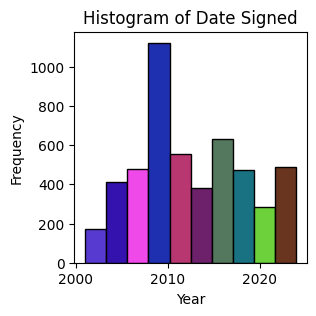

In [37]:
bins = 10
feature_name = 'Date Signed'
feature = combined_df[feature_name].dt.year()
colors = np.random.rand(bins, 3)
plt.figure(figsize=(3, 3)) 
plt.hist(feature, bins=bins, edgecolor='black')
for i, patch in enumerate(plt.gca().patches):
    patch.set_facecolor(colors[i % len(colors)])

plt.ylabel('Frequency')
plt.xlabel('Year')
plt.title(f'Histogram of {feature_name}')
plt.show()

In [32]:
feature_name = 'Region'
feature = combined_df['Region']
colors = np.random.rand(len(feature.unique()), 3)
plt.figure(figsize=(3,3)) 
plt.hist(feature, bins=len(feature.unique()), edgecolor='black')
for i, patch in enumerate(plt.gca().patches):
    patch.set_facecolor(colors[i % len(colors)])

plt.ylabel('Frequency')
plt.xlabel('Region')
plt.title(f'Histogram of {feature_name}')
plt.show()

NameError: name 'df' is not defined

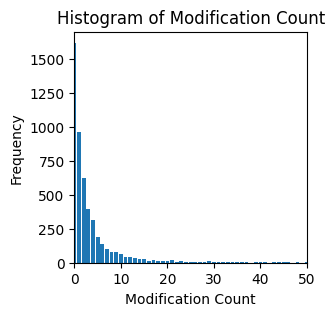

In [39]:
feature_name = 'Modification Count'

counts = combined_df[feature_name].value_counts().sort(feature_name)
x = counts[feature_name].to_numpy()
y = counts['count'].to_numpy()
plt.figure(figsize=(3, 3)) 
plt.bar(x, y)

plt.xlabel(feature_name)
plt.ylabel('Frequency')
plt.title(f'Histogram of {feature_name}')
plt.xlim(0,50)
plt.show()

(0.0, 817255.0)

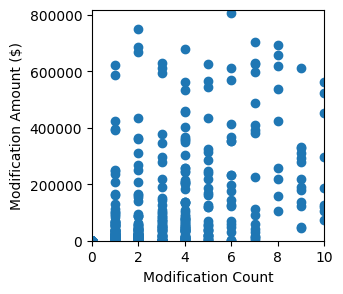

In [40]:
# linear relationship between mod number and mod amount?
min_df = combined_df[:1000]
plt.figure(figsize=(3, 3)) 
plt.scatter(min_df['Modification Count'],min_df['Total Modified Action Obligation ($)'])
plt.xlabel('Modification Count')
plt.ylabel('Modification Amount ($)')
plt.xlim(0,min_df['Modification Count'].quantile(0.90))
plt.ylim(0,min_df['Total Modified Action Obligation ($)'].quantile(0.90))

##### Bucketing Data with Outlier Removal

In [41]:
# Action Obligation Quartiles

df = num_df_encoded

q1, q2, q3 = np.percentile(df["Action Obligation ($)"].to_numpy(), [25, 50, 75])

subset_ao_0_25 = df.filter(pl.col("Action Obligation ($)") <= q1)
subset_ao_0_25_clip_threshold = np.percentile(df["Action Obligation ($)"].to_numpy(), [10, 90])
subset_ao_0_25_clipped = df.filter(
    (pl.col("Action Obligation ($)") >= subset_ao_0_25_clip_threshold[0]) &
    (pl.col("Action Obligation ($)") <= subset_ao_0_25_clip_threshold[1])
)

print(num_df_encoded["Action Obligation ($)"].describe())
print(subset_ao_0_25_clipped["Action Obligation ($)"].describe())

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 4986.0       │
│ null_count ┆ 0.0          │
│ mean       ┆ 3.5235e6     │
│ std        ┆ 1.7585e7     │
│ min        ┆ 0.0          │
│ 25%        ┆ 68292.0      │
│ 50%        ┆ 309985.0     │
│ 75%        ┆ 1.396989e6   │
│ max        ┆ 5.70746952e8 │
└────────────┴──────────────┘
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ value         │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 3988.0        │
│ null_count ┆ 0.0           │
│ mean       ┆ 818280.080993 │
│ std        ┆ 1.1571e6      │
│ min        ┆ 16107.0       │
│ 25%        ┆ 99294.0       │
│ 50%        ┆ 309985.0      │
│ 75%        ┆ 964000.0      │
│ max        ┆ 5.8528e6      │
└────────────┴───────────────┘


In [42]:
# Modified Action Obligation Quartiles

q1, q2, q3 = np.percentile(df["Total Modified Action Obligation ($)"].to_numpy(), [25, 50, 75])

subset_mao_0_25 = df.filter(pl.col("Total Modified Action Obligation ($)") <= q1)
subset_mao_0_25_clip_threshold = np.percentile(df["Total Modified Action Obligation ($)"].to_numpy(), [10, 90])
subset_mao_0_25_clipped = df.filter(
    (pl.col("Total Modified Action Obligation ($)") >= subset_ao_0_25_clip_threshold[0]) &
    (pl.col("Total Modified Action Obligation ($)") <= subset_ao_0_25_clip_threshold[1])
)

print(subset_ao_0_25_clipped["Total Modified Action Obligation ($)"].describe())
subset_ao_0_25_clipped.head()[:1]

shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ value         │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 3988.0        │
│ null_count ┆ 0.0           │
│ mean       ┆ 195539.697844 │
│ std        ┆ 2.5093e6      │
│ min        ┆ 0.0           │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 2849.0        │
│ 75%        ┆ 60882.0       │
│ max        ┆ 1.46829367e8  │
└────────────┴───────────────┘


Contract ID,Contracting Agency ID,PSC,Region,Business Entity ID,Action Obligation ($),Modification Count,Total Modified Action Obligation ($),Competition Type,Bids
str,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GS11P14MAP0340""",60,219,0,1978,644325,1,28426,0,1


In [43]:
# Business Frequency, isolated vs. multiple

id_counts = df.group_by("Business Entity ID").agg(pl.count().alias("count"))
df_with_counts = df.join(id_counts, on="Business Entity ID")
df_multiple = df_with_counts.filter(pl.col("count") > 1).select(df.columns)
df_iso = df_with_counts.filter(pl.col("count") == 1)

# clip to under 75 percentile
print(df_multiple['Business Entity ID'].value_counts().describe())
df_multiple = df_with_counts.filter(pl.col("count") <= 4).select(df.columns)
df_multiple.head()[:1]

shape: (9, 3)
┌────────────┬────────────────────┬──────────┐
│ statistic  ┆ Business Entity ID ┆ count    │
│ ---        ┆ ---                ┆ ---      │
│ str        ┆ f64                ┆ f64      │
╞════════════╪════════════════════╪══════════╡
│ count      ┆ 890.0              ┆ 890.0    │
│ null_count ┆ 0.0                ┆ 0.0      │
│ mean       ┆ 1399.583146        ┆ 3.485393 │
│ std        ┆ 781.814919         ┆ 8.735863 │
│ min        ┆ 3.0                ┆ 2.0      │
│ 25%        ┆ 736.0              ┆ 2.0      │
│ 50%        ┆ 1402.0             ┆ 2.0      │
│ 75%        ┆ 2046.0             ┆ 4.0      │
│ max        ┆ 2779.0             ┆ 253.0    │
└────────────┴────────────────────┴──────────┘


Contract ID,Contracting Agency ID,PSC,Region,Business Entity ID,Action Obligation ($),Modification Count,Total Modified Action Obligation ($),Competition Type,Bids
str,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GS11P14MAP0340""",60,219,0,1978,644325,1,28426,0,1


In [44]:
# subset by region

southeast_df = combined_df.filter(combined_df['Region'] == 'Southeast')
southwest_df = combined_df.filter(combined_df['Region'] == 'Southeast')
northeast_df = combined_df.filter(combined_df['Region'] == 'Northeast')
midwest_df = combined_df.filter(combined_df['Region'] == 'Midwest')
west_df = combined_df.filter(combined_df['Region'] == 'West')

# clip to 25 - 75 action obligation
q1, q2, q3 = np.percentile(southeast_df["Action Obligation ($)"].to_numpy(), [25, 50, 75])
southeast_clipped_df = southeast_df.filter((pl.col("Action Obligation ($)") > q1) & (pl.col("Action Obligation ($)") <= q2))
print(southeast_clipped_df['Action Obligation ($)'].describe())
southeast_clipped_df.head()[:1]

shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ value         │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 520.0         │
│ null_count ┆ 0.0           │
│ mean       ┆ 146664.009615 │
│ std        ┆ 56305.904488  │
│ min        ┆ 63860.0       │
│ 25%        ┆ 97650.0       │
│ 50%        ┆ 140000.0      │
│ 75%        ┆ 188730.0      │
│ max        ┆ 266805.0      │
└────────────┴───────────────┘


Contract ID,NAICS,Date Signed,Contracting Agency ID,PSC,Region,Business Entity ID,Action Obligation ($),Modification Count,Total Modified Action Obligation ($),Competition Type,Bids
str,i64,date,str,str,str,str,i64,i64,i64,str,i64
"""GS04P06EXC0050""",236220,2006-02-27,"""4740""","""Z111""","""Southeast""","""MMJFMSLBN668""",181643,3,4198,"""Restricted""",1


In [45]:
# by type of competition (Open or Restricted)

open_df = combined_df.filter(combined_df['Competition Type'] == 'Open')
restricted_df = combined_df.filter(combined_df['Competition Type'] == 'Restricted')

# clip to 25 - 75 bids
q1, q2, q3 = np.percentile(open_df["Bids"].to_numpy(), [25, 50, 75])
open_df_clipped = open_df.filter((pl.col("Bids") > q1) & (pl.col("Bids") <= q2))
print(open_df['Bids'].describe())
open_df_clipped.head()[:1]

shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 3203.0   │
│ null_count ┆ 0.0      │
│ mean       ┆ 3.40306  │
│ std        ┆ 5.166456 │
│ min        ┆ 1.0      │
│ 25%        ┆ 1.0      │
│ 50%        ┆ 2.0      │
│ 75%        ┆ 4.0      │
│ max        ┆ 123.0    │
└────────────┴──────────┘


Contract ID,NAICS,Date Signed,Contracting Agency ID,PSC,Region,Business Entity ID,Action Obligation ($),Modification Count,Total Modified Action Obligation ($),Competition Type,Bids
str,i64,date,str,str,str,str,i64,i64,i64,str,i64
"""GS11P16MKC7121""",236220,2016-02-26,"""4740""","""Z2AA""","""Southeast""","""M1G5TARMJJT4""",8097000,11,494980,"""Open""",2


---

### Model Updates

#### Performance + Other Anomaly Detection Metrics Discussion

Since the problem is unsupervised, standard performance metrics for classification e.g. AUPRC and/or AUROC cannot be used since there is no ground truth. 

- Synthetic Dataset with Ground Truth Labels (enables Supervised Learning and corresponding standard classification metrics)
- Reconstruction Error (with VAE)
- Metrics from Topological Data Analysis (no latent topological structure)
    - Persistent Homology and Diagrams
    - Distance and Projection Metrics

#### Neo4J AuraDB

#### Sample Queries/Questions to determine uncommon instances

1. Full and Open Competitions with only 1 bid in a region where the number of average bids is high.

2. For the same PSC, Region, etc. and open competition, one vendor is mostly winning.

3. Competitors frequently subcontract for one another.
4. A small business set aside (SBA) contract has a contractor of larger capitalization subcontracting under it.

5. Long time between solictiation date to date signed, few bids, same contractor for a contract that usually has a higher average number of bids.

6. Prime contractor sudden change in behavior, e.g. only working in Midwest for last few years now only works in Southeast.

7. For similar contract, prime contractor did not work with a subcontractor before a certain point, now works with the same subcontractor for all contracts past a certain date.

8. If there is seasonal patterns in who wins contracts e.g. Prime Contractor 1 always wins conracts in the spring and Prime Contractor 2 does not and it flips in winter.

9. A contractor suddenly only does subcontracting work for (maybe for the same company across different contracts) similar contracts where it was the prime contractor for.

10. A large contractor (maybe similar to others) that should be engaging in Full and Open competition but is able to somehow only get Restricted Contracts as defined by FAR 6.302.

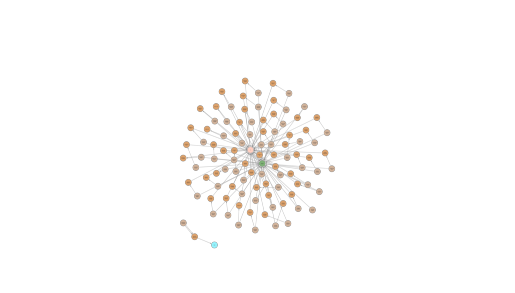

In [46]:
neo4j_scene = os.path.join(assets_dir, 'bloom-visualisation.png')
img = mpimg.imread(neo4j_scene)
plt.imshow(img)
plt.axis('off')
plt.show()

#### Setting up a Graph for More Sophisticated Analysis

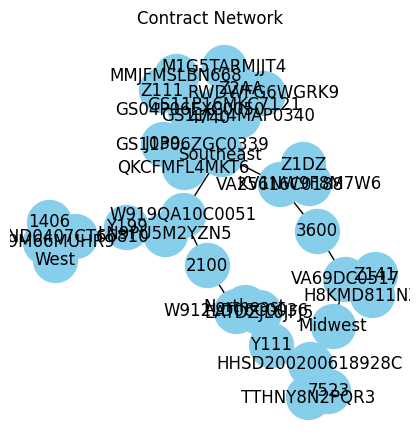

In [47]:
G = nx.Graph()

min_df = df[:10]

node_types = {
    'contract_id': [],
    'contracting_agency': [],
    'business_entity': [],
    'region': [],
    'psc': []
}

for row in min_df.iter_rows(named=True):
    contract_id = row['Contract ID']
    contracting_agency = row['Contracting Agency ID']
    business_entity = row['Business Entity ID']
    region = row['Region']
    psc = row['PSC']

    G.add_edge(region, contract_id)
    G.add_edge(contracting_agency, contract_id)
    G.add_edge(contract_id, business_entity)
    G.add_edge(contract_id, psc)

    node_types['contract_id'].append(contract_id)
    node_types['contracting_agency'].append(contracting_agency)
    node_types['business_entity'].append(business_entity)
    node_types['region'].append(region)
    node_types['psc'].append(psc)

# Define colors for each node type
color_map = {
    'contract_id': 'red',
    'contracting_agency': 'blue',
    'business_entity': 'green',
    'region': 'purple',
    'psc': 'orange'
}

# Assign colors to nodes
node_colors = []
for node in G.nodes():
    for node_type, nodes in node_types.items():
        if node in nodes:
            node_colors.append(color_map[node_type])
            break

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_size=1000, node_color=node_colors, font_size=10, edge_color="gray")
plt.title("Contract Network with Node Types")
plt.show()

##### Connected Components

In [48]:
connected_components = list(nx.connected_components(G))

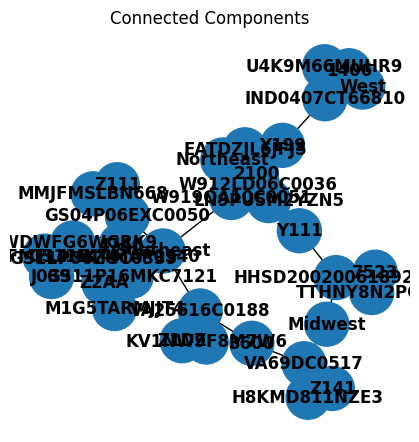

In [49]:
colors = plt.cm.get_cmap('tab10', len(connected_components)) 
node_color = []
for component_idx, component in enumerate(connected_components):
    for node in component:
        node_color.append(colors(component_idx))

plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=node_color, node_size=1000, font_size=12, font_weight='bold')
plt.title("Connected Components")
plt.show()

#### Central Nodes

In [50]:
degree_centrality = nx.degree_centrality(G)
degree_centrality["Southeast"]

0.17142857142857143

#### Degree Distribution

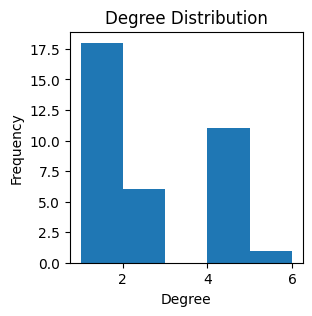

In [51]:
degree_sequence = [d for n, d in G.degree()]
plt.figure(figsize=(3, 3)) 
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 1))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

#### Graph Clustering

In [52]:
communities = community_louvain.best_partition(G)

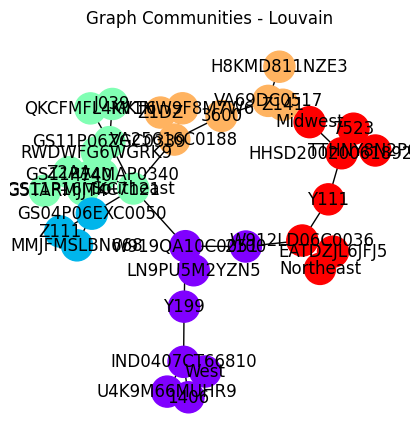

In [53]:
plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G) 
node_color = [communities[node] for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_color=node_color, cmap=plt.cm.rainbow, node_size=500, font_size=12)
plt.title("Graph Communities - Louvain")
plt.show()

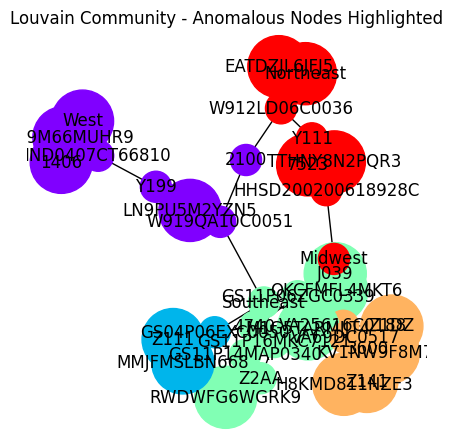

In [54]:
high_low = []

community_sizes = {}
for node, comm in communities.items():
    if comm not in community_sizes:
        community_sizes[comm] = 0
    community_sizes[comm] += 1

# high centrality low size 
# for node, comm in communities.items():
#     if degree_centrality[node] > (1 / community_sizes[comm]):
#         high_low.append(node)


isolated = [node for node, deg in G.degree() if deg == 0]
low = [node for node, deg in G.degree() if deg <= 1]

anomalous_nodes = list(set(high_low + isolated + low))

plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G)
node_color = [communities[node] for node in G.nodes()]
node_size = [500 if node not in anomalous_nodes else 2000 for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_color=node_color, cmap=plt.cm.rainbow, node_size=node_size, font_size=12)
plt.title("Louvain Community - Anomalous Nodes Highlighted")
plt.show()

#### More Sophisticated Graph Models to Explore (Works for Heterogenous Graphs with Edge Features)

1. Variational Graph Autoencoder for Compressing Graph [(Source)](https://www.amazon.science/blog/anomaly-detection-for-graph-based-data)


2. InductiveGRL Process [(Source)](https://www.kaggle.com/code/jawherjabri/fraud-detection-with-gnn)
 - Graph Sample and Aggregation (GraphSage)
 - Fast Inductive Graph Representation Learning (FI-GRL)

3. Topological Data Analysis [(Source)](https://www.quantmetry.com/blog/topological-data-analysis-with-mapper/)

3. Spectral clustering - issue: not smooth manifold [(Source)](https://link.springer.com/chapter/10.1007/978-981-99-4823-9_6)

4. Model Toolbox [(Source)](https://github.com/safe-graph/graph-fraud-detection-papers)

---

### Next Steps

$\textbf{This Week:}$

$\textit{Verification}$
 - Data is Collected Correctly (do some checks and finish any remaining collection)
 - Final Processed Dataframe
 
$\textit{Fine-Tuning Simple Approaches for Anomaly Detection}$
 - Using Neo4J with a query list to determine anomalous nodes
 - Trying different standard graph clustering algorithms besides Louvain e.g. Leiden
 - Trying different methods for anomalous node detection e.g. isolated nodes
 
$\textbf{Next Week...:}$

$\textit{Sophisticated Graph Model Inference}$
 - Trying the first two models and maybe others from toolbox: variational graph autoencoder, inductive-GRL
 - Determining whether to use more models
 
 
$\textit{If Time Permits...}$
- Trying another sector e.g. road development NAICS: 237300 
 

---

## Appendix

### Special Restricted Contract Types

- FAR 6.302 (Circumstances enabling non full competititive practices): will need to write some regex to check 
   'Competitive Procedures / Other Than Full And Open Competition' box)
     - 6.302-1 Only one responsible source and no other supplies or services will satisfy agency requirements.
     - 6.302-2 Unusual and compelling urgency.
     - 6.302-3 Industrial mobilization; engineering, developmental, or research capability; or expert services.
     - 6.302-4 International agreement.
     - 6.302-5 Authorized or required by statute.
     - 6.302-6 National security.
     - 6.302-7 Public interest.
 - FAR 18 (Emergency Acquisitions)
 - *SBA designated contracts
     - 8(a) Business Development program
     - HUBZone program
     - Women-Owned Small Business program
     - Service-Disabled Veteran-Owned Small Business program
 - When entity location components are empty (e.g. Environmental Assessment and REM)

### Additional Questions

1. Why are companies omitted from FPDS after indictments (e.g. Evans LLC or AGO)? Is there any trace (do records of these anomalous companies still exist in any federal database)?
	- consider creating synthetic subgraphs based on the indictment reports or investigation information
2. What is the average renumeration per each case for cases solved by the [PCSF](https://www.justice.gov/atr/procurement-collusion-strike-force) ?
3. What is the collective average monetary resources allocated to each case by the [PCSF](https://www.justice.gov/atr/procurement-collusion-strike-force) ?
4. What is the average financial harm incurred per case by the defendants for all cases prosecuted by [PCSF](https://www.justice.gov/atr/procurement-collusion-strike-force) ?
5. According to the breakdown of cases prosecuted there are ~ 60 guilty pleas/ ~ 110 open cases?
	- divided by year?
6. Of the PCSF investigations, how many were resolved through some analytical/"data science" method? How many of them were through whistleblowers or internal document exposure?
7. What is the average investigation length?
	- from the initial instances of illegal activity to being picked up by PCSF to indictment?
8. What sectors/subsectors have the worst cases?
9. What is the ratio between the PCSF manpower : cases open/resolved? Has the increase in manpower contributed to more cases being brought forth or roughly the same?
10. How can you integrate "irregular" cases in graph?